In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
import mpl_finance as mpf
plt.rcParams['font.family'] = 'SimHei'

from local_utilities import load_as_df

In [2]:
stock_list = load_as_df('select * from base_stocks where market = "主板"')
stock_list = stock_list.set_index('ts_code')
code_list = list(stock_list.index)

s1,s2,s3,s4 = code_list[:500], code_list[500:1000], code_list[1000:1500], code_list[1500:]
ts_code = s1[0]

In [3]:
# 数据处理函数
def trade_days(ts_code, start_day='2019-01-01'):
    df_days = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    return df_days

def find_spec(ts_code, start_day='2019-01-01'):
    df_days = trade_days(ts_code, start_day)
    chg_times, vol_times = 0, 0
    try:
        if df_days.shape[0] > 0:
            spec_arr = pd.qcut(np.abs(df_days.pct_chg), 10, duplicates='drop').value_counts()
            bar_chg = spec_arr.keys()[0].left
            bar_vol = pd.qcut(np.abs(df_days.vol), 10).value_counts().keys()[0].left
            chg_times, vol_times = df_days[-10:][df_days.pct_chg > bar_chg].shape[0], df_days[-10:][df_days.vol > bar_vol].shape[0]
    except Exception as e:
        print('ts_code:{}, err:{}'.format(ts_code, e))
    return (ts_code, chg_times, vol_times)

In [ ]:
# 绘图函数
def ana_candle_vol(ndays):
    _,ax = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    # candle chart
    can_ax, vol_ax = ax[0], ax[1]
    can_ax.xaxis_date()
    can_ax.autoscale_view()
    d = date2num(ndays.index)
    ochl = zip(d, ndays.open, list(ndays.close), list(ndays.high), list(ndays.low))
    mpf.candlestick_ochl(can_ax,quotes=ochl,width=0.6, colorup='red',colordown='green', alpha=0.6)
    # bar chart
    vol_ax.bar(x=d, height=ndays.vol, alpha=0.7)
    vol_ax.xaxis_date()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [4]:
spec_list = []
for s in s1:
    spec_list.append(find_spec(s))

In [5]:
df_spec = pd.DataFrame(spec_list, columns=('ts_code', 'chg_times', 'vol_times'))
df_spec = df_spec.set_index('ts_code')
df_spec = df_spec[(df_spec.chg_times > 2) & (df_spec.vol_times > 1)].sort_values(by='chg_times', ascending=False)
df_spec = df_spec.join(stock_list)

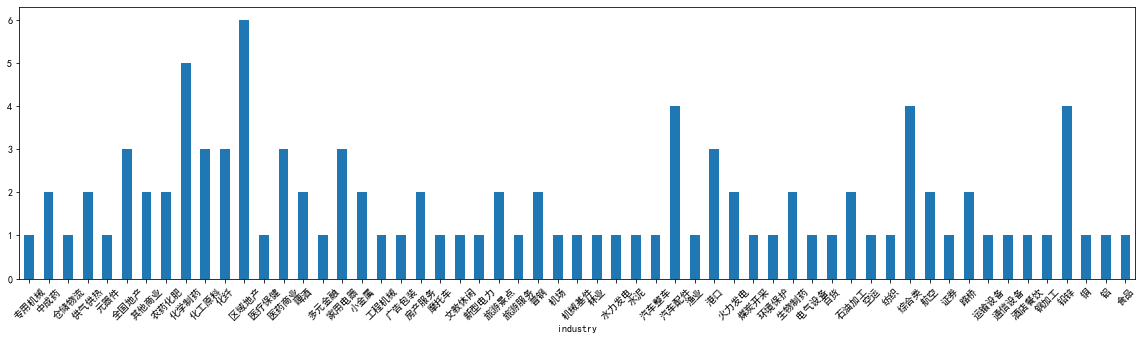

In [12]:
df_spec.groupby('industry', as_index=True).count()['symbol'].plot(kind='bar', figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

In [32]:
df_all = pd.concat([df_spec,stock_list], axis=1)

Text(0, 0.5, 'price abnormal pct')

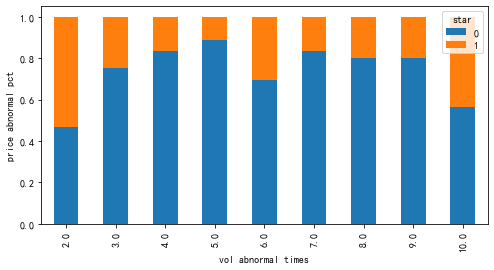

In [33]:
df_all[:4]
df_all['star'] = np.where(df_all.chg_times>5, 1, 0)
xt = pd.crosstab(df_all.vol_times, df_all.star )
xt_pct = xt.div(xt.sum(1).astype(float), axis=0)
xt_pct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.xlabel('vol abnormal times')
plt.ylabel('price abnormal pct')

In [23]:
def load_tickers(ts_code, start_day='2019-01-01'):
    tf_trend = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    tf_trend = tf_trend.set_index('trade_date')
    return tf_trend

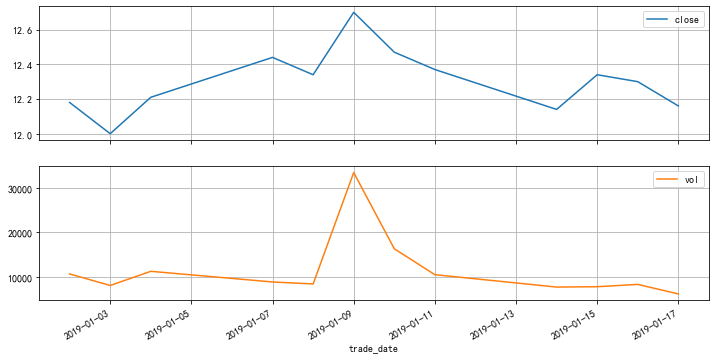

In [24]:
load_tickers('000411.SZ')[:12][['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))
plt.show()

In [17]:
# bins = [-np.inf, 60, 80, 100, np.inf]
# pd.cut(np.arange(1000)%100,bins=bins).value_counts()

tdays = trade_days(ts_code='000411.SZ')
tdays = tdays.set_index('trade_date')
tchgs = pd.qcut(np.abs(tdays.pct_chg), 5)

In [8]:
pd.get_dummies(tchgs)

,"(-0.001, 0.413]","(0.413, 0.845]","(0.845, 1.492]","(1.492, 2.538]","(2.538, 10.014]"
trade_date,,,,,
2019-01-02,0,0,0,0,1
2019-01-03,0,0,1,0,0
2019-01-04,0,0,0,1,0
2019-01-07,0,0,0,1,0
2019-01-08,0,1,0,0,0
...,...,...,...,...,...
2020-07-27,0,0,0,0,1
2020-07-28,0,0,0,0,1
2020-07-29,0,0,0,0,1


In [26]:
import seaborn as sb

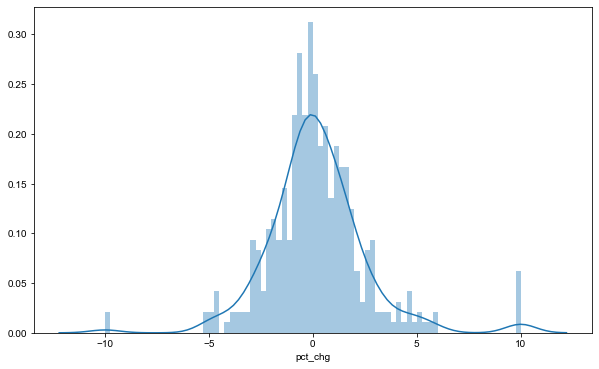

In [34]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10,6))
sb.distplot(tdays.pct_chg, bins=80)
plt.show()

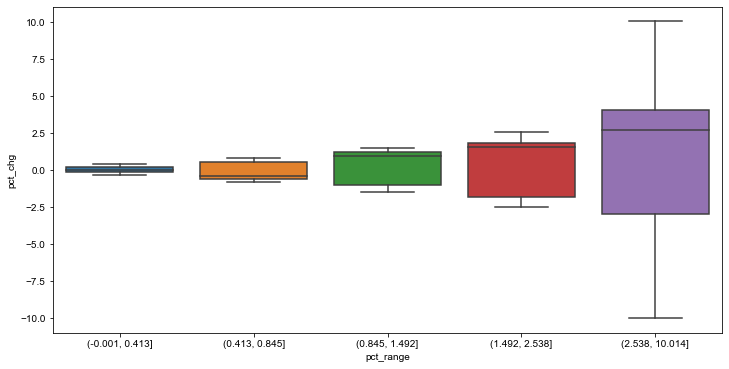

In [28]:
plt.figure(figsize=(12, 6))
p1 = tchgs.rename('pct_range')
p2 = pd.DataFrame(p1)
p3 = tdays.join(p2)
sb.boxplot(x='pct_range', y='pct_chg', data=p3)
plt.show()

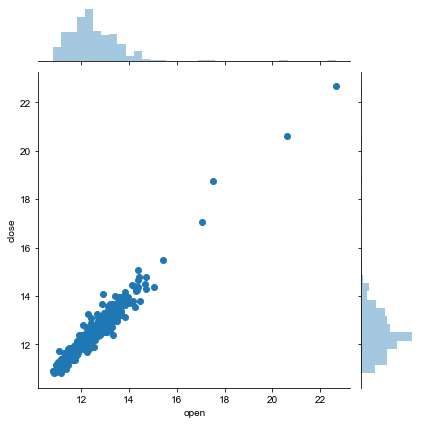

In [29]:
sb.jointplot(tdays.open, np.abs(tdays.close))
plt.show()

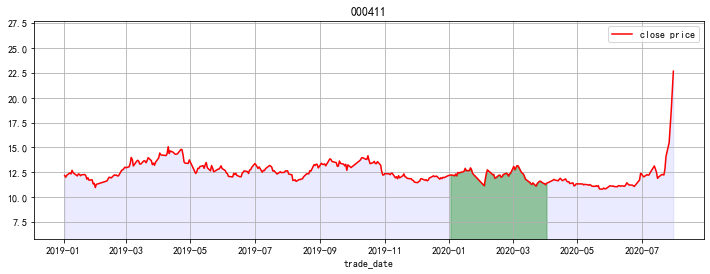

In [19]:
t1 = pd.to_datetime('2020-01-02').date()
t2 = pd.to_datetime('2020-04-02').date()

tdays.close.plot(figsize=(12,4),c='r',grid=True)
plt.fill_between(tdays.index, 0, tdays.close, color='blue', alpha=.08)
plt.fill_between(tdays[t1:t2].index, tdays[t1:t2].close, color='green', alpha=.38)

plt.ylim(np.min(tdays.close) - 5, np.max(tdays.close) + 5)
plt.legend(['close price'], loc='best')
plt.title('000411')
# plt.annotate('sell for profit', xy=)
plt.show()

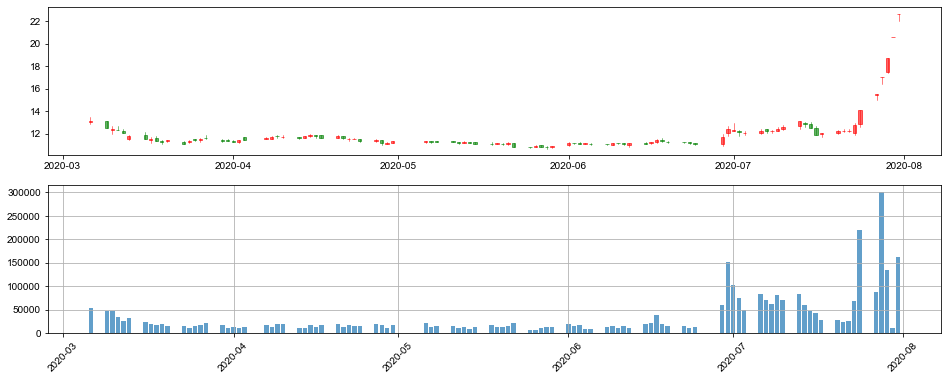

In [66]:
ana_candle_vol(tdays[-100:])